# Interpreting nodes and edges with saliency maps in GCN


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/interpretability/gcn-node-link-importance.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/interpretability/gcn-node-link-importance.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This demo shows how to use integrated gradients in graph convolutional networks to obtain accurate importance estimations for both the nodes and edges. The notebook consists of three parts:
- setting up the node classification problem for Cora citation network
- training and evaluating a GCN model for node classification
- calculating node and edge importances for model's predictions of query ("target") nodes

<a name="refs"></a>
**References**

[1] Axiomatic Attribution for Deep Networks. M. Sundararajan, A. Taly, and Q. Yan.
    Proceedings of the 34th International Conference on Machine Learning, Sydney, Australia, PMLR 70, 2017
    ([link](https://arxiv.org/pdf/1703.01365.pdf)).
    
[2] Adversarial Examples on Graph Data: Deep Insights into Attack and Defense. H. Wu, C. Wang, Y. Tyshetskiy, A. Docherty, K. Lu, and L. Zhu. arXiv: 1903.01610 ([link](https://arxiv.org/abs/1903.01610)).

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import os
import time
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model, regularizers
from sklearn import preprocessing, feature_extraction, model_selection
from copy import deepcopy
import matplotlib.pyplot as plt
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the CORA network

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load()

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [5]:
train_subjects, test_subjects = model_selection.train_test_split(
    subjects, train_size=140, test_size=None, stratify=subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [6]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

all_targets = target_encoding.transform(subjects)

### Creating the GCN model in Keras

To feed data from the graph to the Keras model we need a generator. Since GCN is a full-batch model, we use the `FullBatchNodeGenerator` class.

Note: For interpretability we require a dense matrix so we set `sparse=False` in the `FullBatchNodeGenerator`.

In [7]:
generator = FullBatchNodeGenerator(G, sparse=False)

Using GCN (local pooling) filters...


For training we map only the training nodes returned from our splitter and the target values.

In [8]:
train_gen = generator.flow(train_subjects.index, train_targets)

Now we can specify our machine learning model: tn this example we use two GCN layers with 16-dimensional hidden node features at each layer with ELU activation functions.

In [9]:
layer_sizes = [16, 16]
gcn = GCN(
    layer_sizes=layer_sizes,
    activations=["elu", "elu"],
    generator=generator,
    dropout=0.3,
    kernel_regularizer=regularizers.l2(5e-4),
)

In [10]:
# Expose the input and output tensors of the GCN model for node prediction, via GCN.in_out_tensors() method:
x_inp, x_out = gcn.in_out_tensors()
# Snap the final estimator layer to x_out
x_out = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `x_out` from the final dense layer

In [11]:
model = keras.Model(inputs=x_inp, outputs=x_out)

model.compile(
    optimizer=optimizers.Adam(lr=0.01),  # decay=0.001),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [12]:
val_gen = generator.flow(val_subjects.index, val_targets)

Train the model

In [13]:
history = model.fit(
    train_gen, shuffle=False, epochs=20, verbose=2, validation_data=val_gen
)

Epoch 1/20
1/1 - 0s - loss: 1.9493 - categorical_accuracy: 0.1429 - val_loss: 1.8287 - val_categorical_accuracy: 0.3040
Epoch 2/20
1/1 - 0s - loss: 1.7875 - categorical_accuracy: 0.3214 - val_loss: 1.7499 - val_categorical_accuracy: 0.3040
Epoch 3/20
1/1 - 0s - loss: 1.6701 - categorical_accuracy: 0.3357 - val_loss: 1.6854 - val_categorical_accuracy: 0.3040
Epoch 4/20
1/1 - 0s - loss: 1.5617 - categorical_accuracy: 0.3286 - val_loss: 1.6155 - val_categorical_accuracy: 0.3160
Epoch 5/20
1/1 - 0s - loss: 1.4499 - categorical_accuracy: 0.3786 - val_loss: 1.5322 - val_categorical_accuracy: 0.3680
Epoch 6/20
1/1 - 0s - loss: 1.3278 - categorical_accuracy: 0.5071 - val_loss: 1.4399 - val_categorical_accuracy: 0.4700
Epoch 7/20
1/1 - 0s - loss: 1.1788 - categorical_accuracy: 0.6214 - val_loss: 1.3484 - val_categorical_accuracy: 0.5820
Epoch 8/20
1/1 - 0s - loss: 1.0673 - categorical_accuracy: 0.7571 - val_loss: 1.2649 - val_categorical_accuracy: 0.6440
Epoch 9/20
1/1 - 0s - loss: 0.9381 - cat

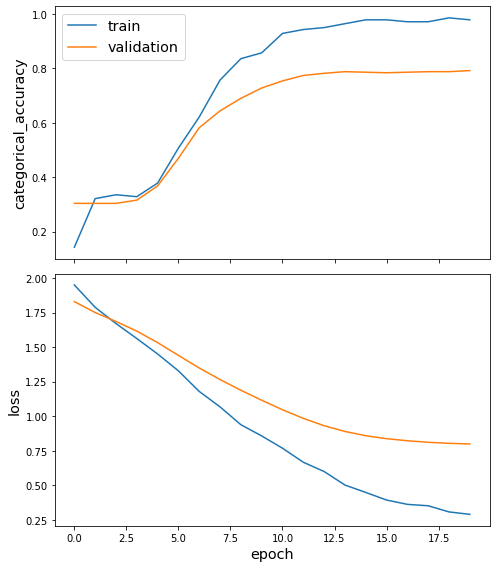

In [14]:
sg.utils.plot_history(history)

Evaluate the trained model on the test set

In [15]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7585
	categorical_accuracy: 0.8037


## Node and link importance via saliency maps

In order to understand why a selected node is predicted as a certain class we want to find the node feature importance, total node importance, and link importance for nodes and edges in the selected node's neighbourhood (ego-net). These importances give information about the effect of changes in the node's features and its neighbourhood on the prediction of the node, specifically:

- **Node feature importance**: Given the selected node $t$ and the model's prediction $s(c)$ for class $c$. The feature importance can be calculated for each node $v$ in the selected node's ego-net where the importance of feature $f$ for node $v$ is the change predicted score $s(c)$ for the selected node when the feature $f$ of node $v$ is perturbed.
- **Total node importance**: This is defined as the sum of the feature importances for node $v$ for all features. Nodes with high importance (positive or negative) affect the prediction for the selected node more than links with low importance. 
- **Link importance**: This is defined as the change in the selected node's predicted score $s(c)$ if the link $e=(u, v)$ is removed from the graph. Links with high importance (positive or negative) affect the prediction for the selected node more than links with low importance. 

Node and link importances can be used to assess the role of nodes and links in model's predictions for the node(s) of interest (the selected node). For datasets like CORA-ML, the features and edges are binary, vanilla gradients may not perform well so we use integrated gradients [[1]](#refs) to compute them.

Another interesting application of node and link importances is to identify model vulnerabilities to attacks via perturbing node features and graph structure (see [[2]](#refs)).

To investigate these importances we use the StellarGraph `saliency_maps` routines:

In [16]:
from stellargraph.interpretability.saliency_maps import IntegratedGradients

Select the target node whose prediction is to be interpreted

In [17]:
graph_nodes = list(G.nodes())
target_nid = 1109199
target_idx = graph_nodes.index(target_nid)
y_true = all_targets[target_idx]  # true class of the target node

In [18]:
all_gen = generator.flow(graph_nodes)
y_pred = model.predict(all_gen)[0, target_idx]
class_of_interest = np.argmax(y_pred)

print(
    "Selected node id: {}, \nTrue label: {}, \nPredicted scores: {}".format(
        target_nid, y_true, y_pred.round(2)
    )
)

Selected node id: 1109199, 
True label: [0 1 0 0 0 0 0], 
Predicted scores: [0.06 0.57 0.15 0.06 0.05 0.04 0.07]


Get the node feature importance by using integrated gradients

In [19]:
int_grad_saliency = IntegratedGradients(model, train_gen)

For the parameters of `get_node_importance` method, `X` and `A` are the feature and adjacency matrices, respectively. `target_idx` is the node of interest, and `class_of_interest` is set as the predicted label of the node. `steps` indicates the number of steps used to approximate the integration in integrated gradients calculation. A larger value of `steps` gives better approximation, at the cost of higher computational overhead.

In [20]:
integrated_node_importance = int_grad_saliency.get_node_importance(
    target_idx, class_of_interest, steps=50
)


To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [21]:
integrated_node_importance.shape

(2708,)

In [22]:
print("\nintegrated_node_importance", integrated_node_importance.round(2))
print("integrate_node_importance.shape = {}".format(integrated_node_importance.shape))
print(
    "integrated self-importance of target node {}: {}".format(
        target_nid, integrated_node_importance[target_idx].round(2)
    )
)


integrated_node_importance [0. 0. 0. ... 0. 0. 0.]
integrate_node_importance.shape = (2708,)
integrated self-importance of target node 1109199: 3.61


Check that number of non-zero node importance values is less or equal the number of nodes in target node's K-hop ego net (where K is the number of GCN layers in the model)

In [23]:
G_ego = nx.ego_graph(G.to_networkx(), target_nid, radius=len(gcn.activations))

In [24]:
print("Number of nodes in the ego graph: {}".format(len(G_ego.nodes())))
print(
    "Number of non-zero elements in integrated_node_importance: {}".format(
        np.count_nonzero(integrated_node_importance)
    )
)

Number of nodes in the ego graph: 202
Number of non-zero elements in integrated_node_importance: 202


We now compute the link importance using integrated gradients [1]. Integrated gradients are obtained by accumulating the gradients along the path between the baseline (all-zero graph) and the state of the graph. They provide better sensitivity for the graphs with binary features and edges compared with the vanilla gradients.

In [25]:
integrate_link_importance = int_grad_saliency.get_integrated_link_masks(
    target_idx, class_of_interest, steps=50
)
print("integrate_link_importance.shape = {}".format(integrate_link_importance.shape))

integrate_link_importance.shape = (2708, 2708)


Some sanity checks:
We expect the number of non-zero elements in the integrated link importance be same or less than the number of real edges in the ego graph.

In [26]:
(X, _, A), _ = train_gen[0]

In [27]:
# The built-in number_of_edges function for the ego graph does not count the self-loops and some reversed edges
# in the non-directed graph so we do the sanity check as the following.
G_ego_edges = set()
for i in np.nonzero(A[0, target_idx])[0]:
    G_ego_edges.add((graph_nodes[target_idx], graph_nodes[i]))
    for j in np.nonzero(A[0, i])[0]:
        G_ego_edges.add((graph_nodes[i], graph_nodes[j]))
print("Number of edges in the ego graph: {}".format(len(G_ego_edges)))
print(
    "Number of non-zero elements in integrate_link_importance: {}".format(
        np.count_nonzero(integrate_link_importance)
    )
)

Number of edges in the ego graph: 210
Number of non-zero elements in integrate_link_importance: 210


We can now find the nodes that have the highest importance to the prediction of the selected node:

In [28]:
sorted_indices = np.argsort(integrate_link_importance.flatten())
N = len(graph_nodes)
integrated_link_importance_rank = [
    (graph_nodes[k // N], graph_nodes[k % N]) for k in sorted_indices[::-1]
]
topk = 10
print(
    "Top {} most important links by integrated gradients are:\n {}".format(
        topk, integrated_link_importance_rank[-topk:]
    )
)

Top 10 most important links by integrated gradients are:
 [(6214, 1105764), (6214, 13960), (6214, 345340), (6214, 6378), (6214, 399339), (6214, 124064), (6214, 95589), (6214, 1106172), (148170, 1128997), (1109199, 6214)]


In [29]:
# Set the labels as an attribute for the nodes in the graph. The labels are used to color the nodes in different classes.
nx.set_node_attributes(G_ego, values={x[0]: {"subject": x[1]} for x in subjects.items()})

In the following, we plot the link and node importance (computed by integrated gradients) of the nodes within the ego graph of the target node. 

For nodes, the shape of the node indicates the positive/negative importance the node has. 'round' nodes have positive importance while 'diamond' nodes have negative importance. The size of the node indicates the value of the importance, e.g., a large diamond node has higher negative importance. 

For links, the color of the link indicates the positive/negative importance the link has. 'red' links have positive importance while 'blue' links have negative importance. The width of the link indicates the value of the importance, e.g., a thicker blue link has higher negative importance.

In [30]:
integrated_node_importance.max()

10.026242917579111

In [31]:
integrate_link_importance.max()

0.15404796169424637

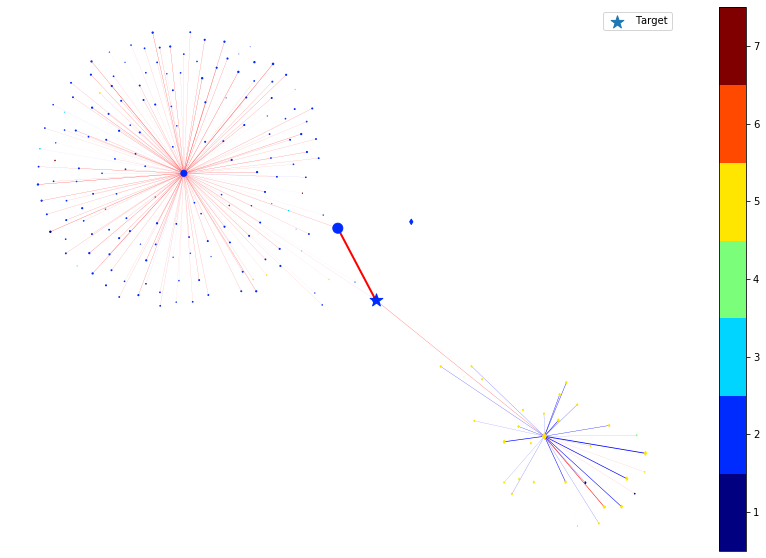

In [32]:
node_size_factor = 1e2
link_width_factor = 2

nodes = list(G_ego.nodes())
colors = pd.DataFrame(
    [v[1]["subject"] for v in G_ego.nodes(data=True)], index=nodes, columns=["subject"]
)
colors = np.argmax(target_encoding.transform(colors), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pos = nx.spring_layout(G_ego)

# Draw ego as large and red
node_sizes = [integrated_node_importance[graph_nodes.index(k)] for k in nodes]
node_shapes = ["o" if w > 0 else "d" for w in node_sizes]

positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
node_size_scale = node_size_factor / np.max(node_sizes)
for k in range(len(nodes)):
    if nodes[k] == target_idx:
        continue
    if node_shapes[k] == "o":
        positive_colors.append(colors[k])
        positive_nodes.append(nodes[k])
        positive_node_sizes.append(node_size_scale * node_sizes[k])

    else:
        negative_colors.append(colors[k])
        negative_nodes.append(nodes[k])
        negative_node_sizes.append(node_size_scale * abs(node_sizes[k]))

# Plot the ego network with the node importances
cmap = plt.get_cmap("jet", np.max(colors) - np.min(colors) + 1)
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=positive_nodes,
    node_color=positive_colors,
    cmap=cmap,
    node_size=positive_node_sizes,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="o",
)
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=negative_nodes,
    node_color=negative_colors,
    cmap=cmap,
    node_size=negative_node_sizes,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="d",
)
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=[target_nid],
    node_size=50 * abs(node_sizes[nodes.index(target_nid)]),
    node_shape="*",
    node_color=[colors[nodes.index(target_nid)]],
    cmap=cmap,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    label="Target",
)

# Draw the edges with the edge importances
edges = G_ego.edges()
weights = [
    integrate_link_importance[graph_nodes.index(u), graph_nodes.index(v)]
    for u, v in edges
]
edge_colors = ["red" if w > 0 else "blue" for w in weights]
weights = link_width_factor * np.abs(weights) / np.max(weights)

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, width=weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors), np.max(colors) + 1))
plt.axis("off")
plt.show()

We then remove the node or edge in the ego graph one by one and check how the prediction changes. By doing so, we can obtain the ground truth importance of the nodes and edges. Comparing the following figure and the above one can show the effectiveness of integrated gradients as the importance approximations are relatively consistent with the ground truth.

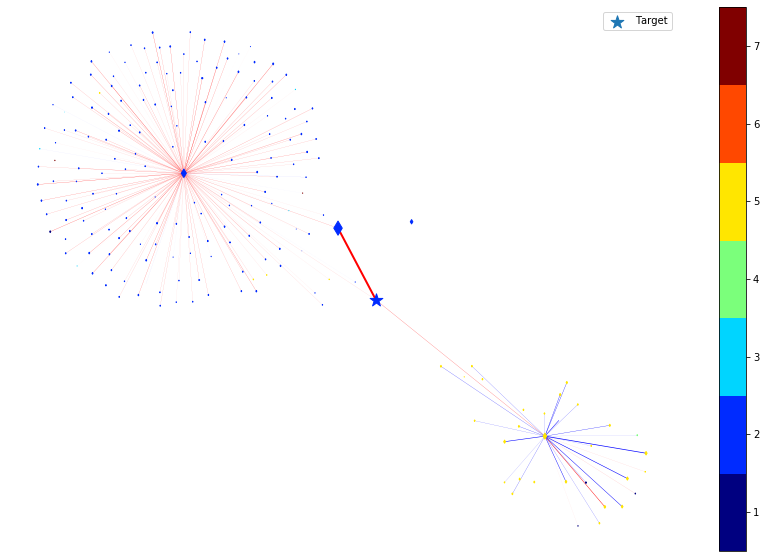

In [33]:
X_bk = deepcopy(X)
A_bk = deepcopy(A)
selected_nodes = np.array([[target_idx]], dtype="int32")
nodes = [graph_nodes.index(v) for v in G_ego.nodes()]
edges = [(graph_nodes.index(u), graph_nodes.index(v)) for u, v in G_ego.edges()]

clean_prediction = model.predict([X, selected_nodes, A]).squeeze()
predict_label = np.argmax(clean_prediction)

groud_truth_node_importance = np.zeros((N,))
for node in nodes:
    # we set all the features of the node to zero to check the ground truth node importance.
    X_perturb = deepcopy(X_bk)
    X_perturb[:, node, :] = 0
    predict_after_perturb = model.predict([X_perturb, selected_nodes, A]).squeeze()
    groud_truth_node_importance[node] = (
        clean_prediction[predict_label] - predict_after_perturb[predict_label]
    )

node_shapes = [
    "o" if groud_truth_node_importance[k] > 0 else "d" for k in range(len(nodes))
]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
# node_size_scale is used for better visulization of nodes
node_size_scale = node_size_factor / max(groud_truth_node_importance)

for k in range(len(node_shapes)):
    if nodes[k] == target_idx:
        continue
    if node_shapes[k] == "o":
        positive_colors.append(colors[k])
        positive_nodes.append(graph_nodes[nodes[k]])
        positive_node_sizes.append(
            node_size_scale * groud_truth_node_importance[nodes[k]]
        )
    else:
        negative_colors.append(colors[k])
        negative_nodes.append(graph_nodes[nodes[k]])
        negative_node_sizes.append(
            node_size_scale * abs(groud_truth_node_importance[nodes[k]])
        )
X = deepcopy(X_bk)
groud_truth_edge_importance = np.zeros((N, N))
for edge in edges:
    A = deepcopy(A_bk)
    if A[0, edge[0], edge[1]] == 0:
        continue
    # we set the weight of a given edge to zero to check the ground truth link importance
    A[:, edge[0], edge[1]] = 0
    predict_after_perturb = model.predict([X, selected_nodes, A]).squeeze()
    groud_truth_edge_importance[edge[0], edge[1]] = (
        predict_after_perturb[predict_label] - clean_prediction[predict_label]
    ) / (0 - 1)
    A[:, edge[0], edge[1]] = 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.get_cmap("jet", np.max(colors) - np.min(colors) + 1)
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=[target_nid],
    node_size=50 * abs(node_sizes[nodes.index(target_idx)]),
    node_color=[colors[nodes.index(target_idx)]],
    cmap=cmap,
    node_shape="*",
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    label="Target",
)
# Draw the ego net
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=positive_nodes,
    node_color=positive_colors,
    cmap=cmap,
    node_size=positive_node_sizes,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="o",
)
nc = nx.draw_networkx_nodes(
    G_ego,
    pos,
    nodelist=negative_nodes,
    node_color=negative_colors,
    cmap=cmap,
    node_size=negative_node_sizes,
    vmin=np.min(colors) - 0.5,
    vmax=np.max(colors) + 0.5,
    node_shape="d",
)
edges = G_ego.edges()
weights = [
    groud_truth_edge_importance[graph_nodes.index(u), graph_nodes.index(v)]
    for u, v in edges
]
edge_colors = ["red" if w > 0 else "blue" for w in weights]
weights = link_width_factor * np.abs(weights) / np.max(weights)

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors, width=weights)
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors), np.max(colors) + 1))
plt.axis("off")
plt.show()

By comparing the above two figures, one can see that the integrated gradients are quite consistent with the brute-force approach. The main benefit of using integrated gradients is scalability. The gradient operations are very efficient to compute on deep learning frameworks with the parallelism provided by GPUs. Also, integrated gradients can give the importance of individual node features, for all nodes in the graph. Achieving this by brute-force approach is often non-trivial. 

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/interpretability/gcn-node-link-importance.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/interpretability/gcn-node-link-importance.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>